In [1]:
from pca_dataflow_V3_variables import *

In [2]:
# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

File exists: test_data\ang20220711t002111_rfl_v2aa2_img_rectified
HDR File exists: test_data\ang20220711t002111_rfl_v2aa2_img_rectified.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

c:\Users\Patrick\anaconda3\envs\geo_env\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (RasterXSize):\t"+str(ncols),"Rows (RasterYSize):\t"+str(nrows)]))

Bands:	425
Cols (RasterXSize):	1008
Rows (RasterYSize):	1007


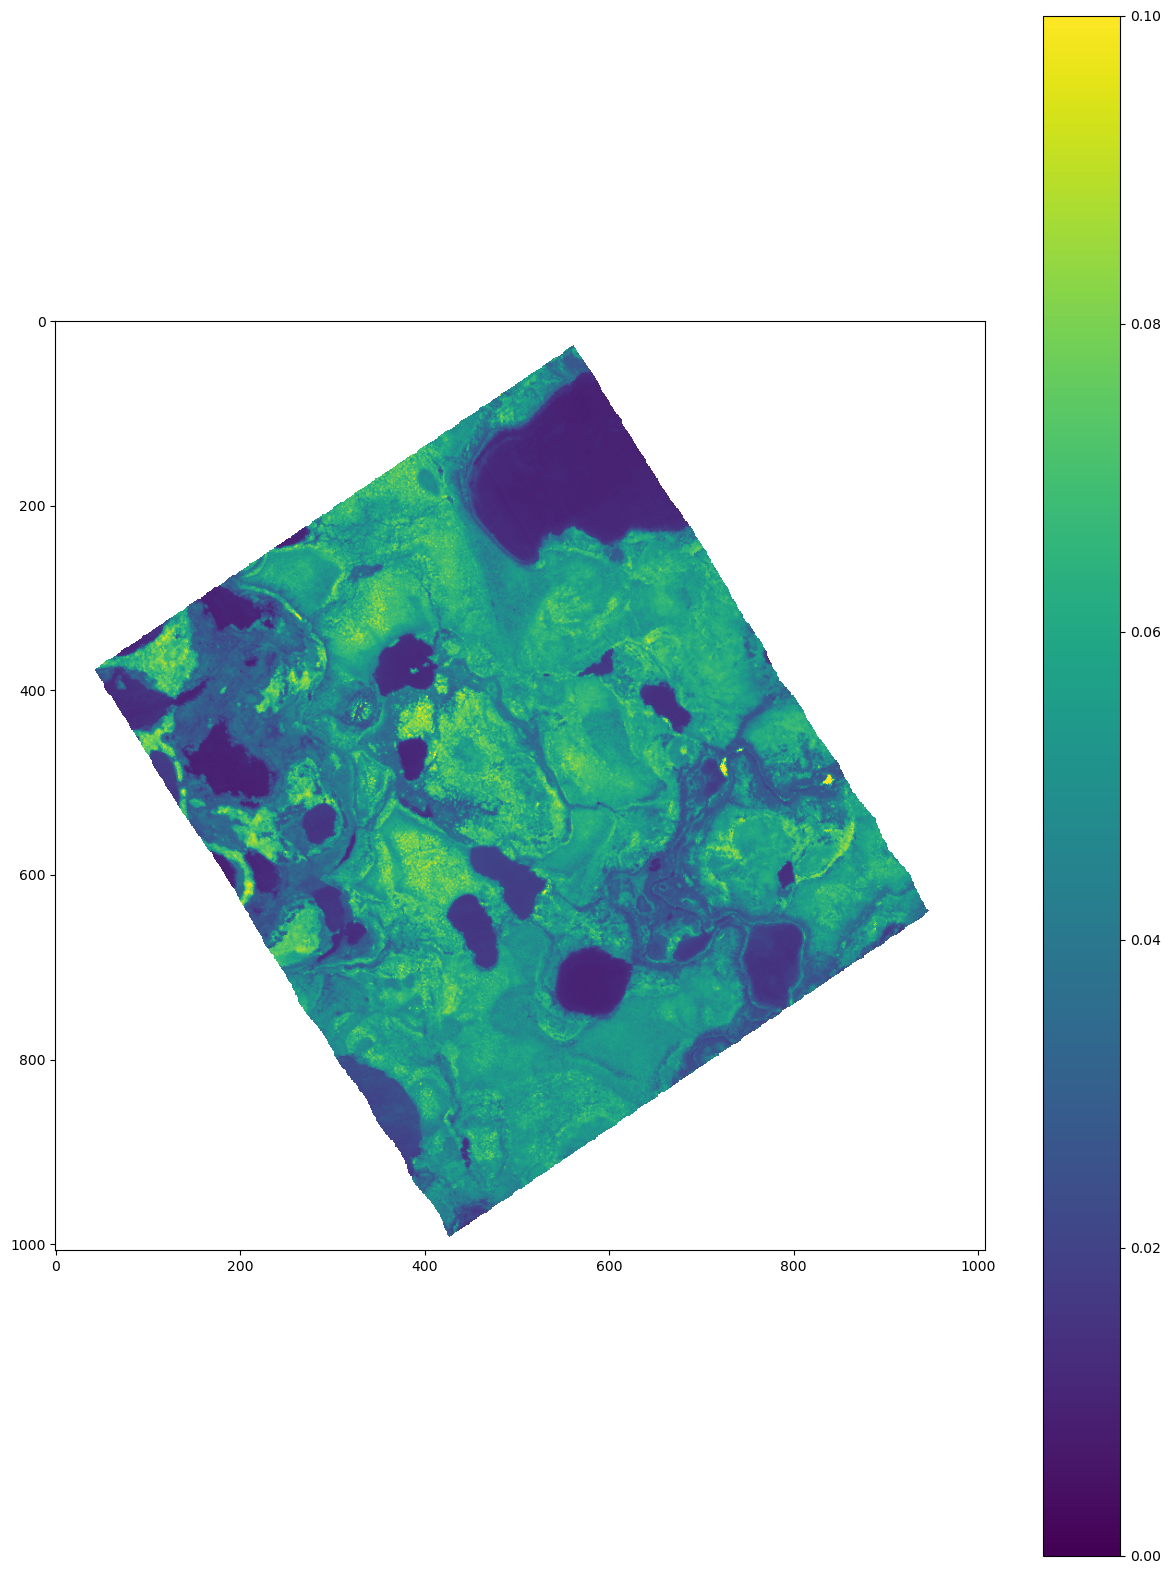

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [15,20]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [6]:
# Define NoData value
nodata_value = -9999

# Extract the required bands (band 57, 34, and 20)
band_57 = img_open.GetRasterBand(57).ReadAsArray()
band_34 = img_open.GetRasterBand(34).ReadAsArray()
band_20 = img_open.GetRasterBand(20).ReadAsArray()

# Replace NoData values with NaN (or any other appropriate value)
# set fill values (-9999.) to 0 for each array
band_57[band_57 == nodata_value], band_34[band_34 == nodata_value], band_20[band_20 == nodata_value] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
band_57_8bit, band_34_8bit, band_20_8bit = scale8bit(band_57), scale8bit(band_34), scale8bit(band_20)

# set rescaled fill pixels back to 0 for each array
band_57_8bit[band_57 == 0], band_34_8bit[band_34 == 0], band_20_8bit[band_20 == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = band_57_8bit, band_34_8bit, band_20_8bit

# Rearrange to (RasterCount, RasterYSize, RasterXSize)
reordered_rgb_stack = np.transpose(rgb_stack, (2, 0, 1))

In [7]:
# Define output file path
RGB_file = os.path.join(input_dir, "output_rgb_image.tif")

# Save the RGB image as a GeoTIFF
save_array(RGB_file, reordered_rgb_stack,reordered_rgb_stack.shape[0], img_open,"GTiff",-9999,gdal.GDT_Byte)

print(f"RGB image saved as {RGB_file}")

RGB image saved as test_data\output_rgb_image.tif


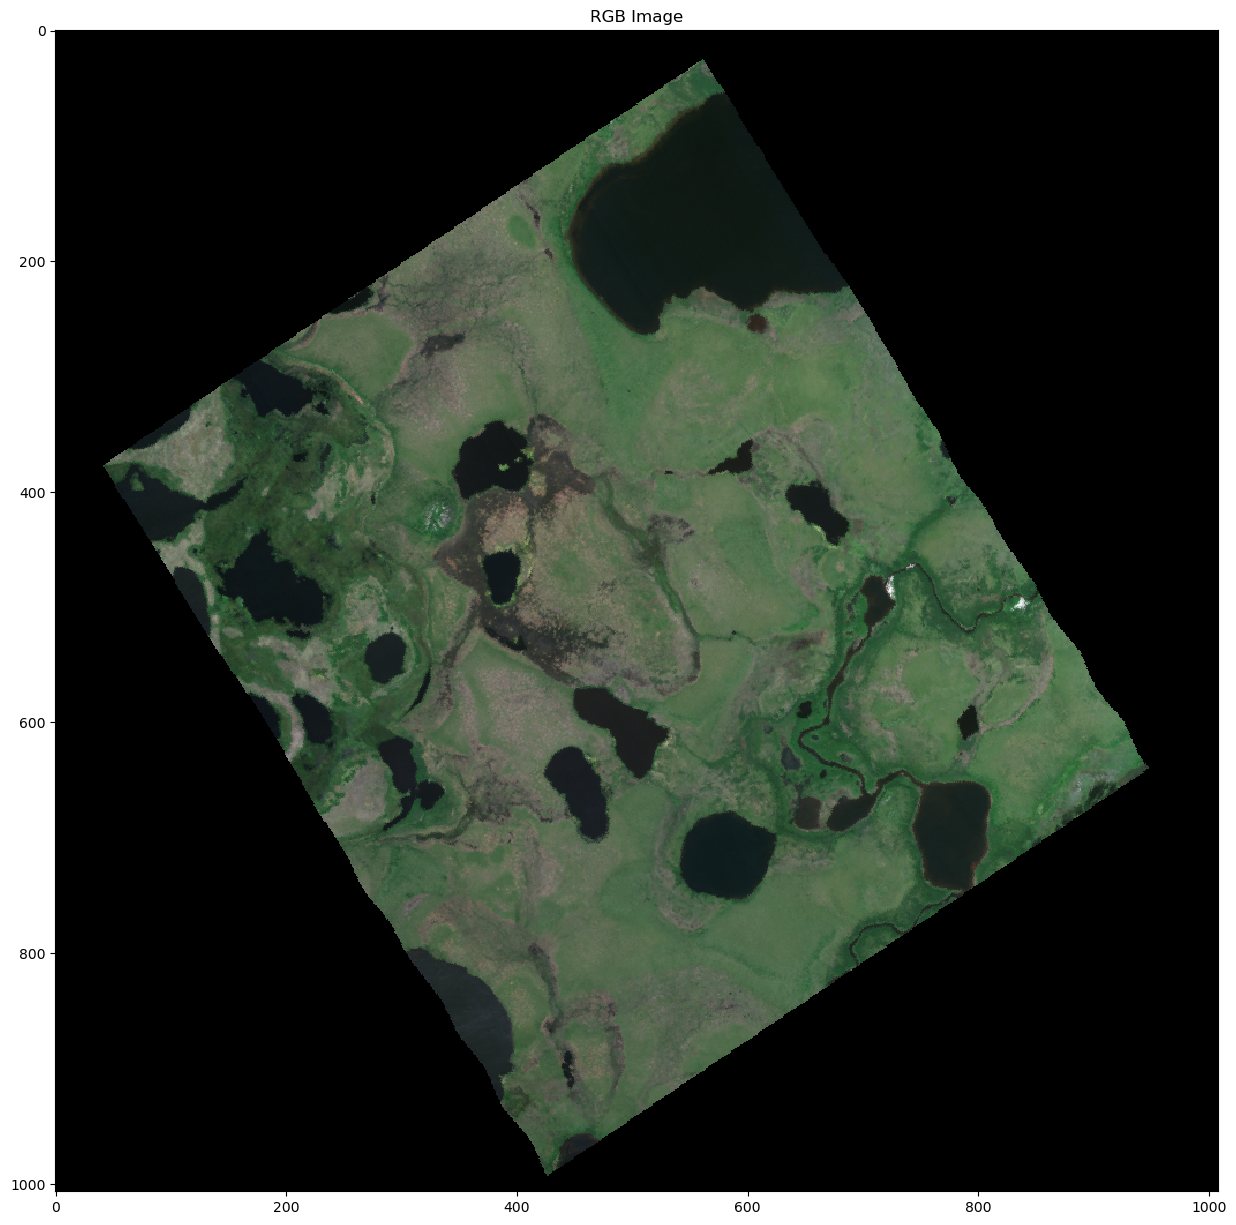

In [8]:
plt.figure(figsize=(15, 20))
plt.imshow(rgb_stack, cmap='bwr', interpolation='none')
plt.title('RGB Image')
plt.show()

In [9]:
del band_57, band_34, band_20, band_57_8bit, band_34_8bit, band_20_8bit, rgb_stack
gc.collect()

9250

# Calculate SAVI

In [10]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65
blue_bands = range(15, 23)    # Bands 15 to 23


# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)
blue_average = calculate_band_average(img_open, blue_bands)

c:\Users\Patrick\Documents\GitHub\UWW200_Master_Thesis_public\MasterThesisPythonCode\pca_dataflow_V3_variables.py:68: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(band_arrays, axis=0), axis=0)


In [11]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# Create a SAVI mask
savi_mask = np.where(SAVI > SAVI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
#savi_mask = np.where(savi_mask == 0, np.nan, 1)

# Save SAVI and savi_mask

# ENVI format
SAVI_file_envi = os.path.join(input_dir, "SAVI")
SAVI_mask_file_envi = os.path.join(input_dir, "SAVI_mask")
save_array(SAVI_file_envi, SAVI, 1, img_open,"ENVI")
save_array(SAVI_mask_file_envi, savi_mask, 1, img_open,"ENVI")

#Geotiff format
SAVI_file = os.path.join(input_dir, "SAVI.tif")
SAVI_mask_file = os.path.join(input_dir, "SAVI_mask.tif")
save_array(SAVI_file, SAVI, 1, img_open,"GTiff")
save_array(SAVI_mask_file, savi_mask, 1, img_open,"GTiff")

print(f'SAVI mask saved as GTiff {SAVI_mask_file}')
print(f'SAVI mask saved as ENVI {SAVI_mask_file_envi}')
print(f'SAVI saved as GTiff {SAVI_mask_file}')
print(f'SAVI saved as ENVI {SAVI_file_envi}')

SAVI mask saved as GTiff test_data\SAVI_mask.tif
SAVI mask saved as ENVI test_data\SAVI_mask
SAVI saved as GTiff test_data\SAVI_mask.tif
SAVI saved as ENVI test_data\SAVI


# Calculate NDWI

In [12]:
# Formula: NDWI = (Green – NIR)/(Green + NIR)

# Define NDWI parameters
# The NDWI values correspond to the following ranges:
# 0,2 – 1 – Water surface,
# 0.0 – 0,2 – Flooding, humidity,
# -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
# -1 – -0.3 – Drought, non-aqueous surfaces

NDWI_threshold = 0.2

# Calculate the SAVI
NDWI = (green_average - nir_average)/(green_average + nir_average)

# Create a SAVI mask
ndwi_mask = np.where(NDWI > NDWI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
ndwi_mask = np.where(ndwi_mask == 0, np.nan, ndwi_mask)

# Save NDWI and ndwi_mask

# ENVI format
NDWI_file_envi = os.path.join(input_dir, "NDWI")
NDWI_mask_file_envi = os.path.join(input_dir, "NDWI_mask")
save_array(NDWI_file_envi, NDWI, 1, img_open,"ENVI")
save_array(NDWI_mask_file_envi, ndwi_mask, 1, img_open,"ENVI")

#Geotiff format
NDWI_file = os.path.join(input_dir, "NDWI.tif")
NDWI_mask_file = os.path.join(input_dir, "NDWI_mask.tif")
save_array(NDWI_file, NDWI, 1, img_open,"GTiff")
save_array(NDWI_mask_file, ndwi_mask, 1, img_open,"GTiff")

print(f'NDWI mask saved as GTiff {NDWI_mask_file}')
print(f'NDWI mask saved as ENVI {NDWI_mask_file_envi}')
print(f'NDWI saved as GTiff {NDWI_file}')
print(f'NDWI saved as ENVI {NDWI_file_envi}')

NDWI mask saved as GTiff test_data\NDWI_mask.tif
NDWI mask saved as ENVI test_data\NDWI_mask
NDWI saved as GTiff test_data\NDWI.tif
NDWI saved as ENVI test_data\NDWI


In [13]:
del nir_bands, green_bands, red_bands, nir_average, green_average, red_average
gc.collect()

0

# Perform PCA

In [14]:
# File path
pca_model_file = os.path.join(input_dir, "pca_model.pkl")
pca_result_file = os.path.join(input_dir, "pca_result.npz")
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

In [15]:
perform_pca = True

if(perform_pca):
    # Load the SAVI mask
    savi_mask_ds = gdal.Open(SAVI_mask_file)
    savi_mask = savi_mask_ds.GetRasterBand(1).ReadAsArray()
    savi_mask = np.where(savi_mask == 1, 1, np.nan)  # Keep only 1s, set others to NaN

    # Prepare hyperspectral image data
    bands = img_open.RasterCount  # Number of bands in the image
    rows, cols = savi_mask.shape

    # Initialize an empty list to store valid pixel data
    valid_pixels = []

    # Define the bands to include based on bblist
    bblist = np.ones((425,))
    bblist[0:14] = 0
    bblist[189:225] = 0
    bblist[281:336] = 0
    bblist[405:] = 0

    # Convert bblist to boolean mask for included bands
    included_bands = np.where(bblist == 1)[0] + 1  # GDAL bands are 1-based
    num_included_bands = len(included_bands)

    # Loop through only the included bands
    valid_pixels = []
    for band_index in included_bands:
        band_data = img_open.GetRasterBand(int(band_index)).ReadAsArray()
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace no-data values with NaN
        # Apply mask
        masked_data = band_data * savi_mask  # Retain only pixels where mask == 1
        valid_pixels.append(masked_data)

    # Stack all bands into a single 3D array (bands, rows, cols)
    image_stack = np.stack(valid_pixels, axis=0)

    # Flatten the image stack (bands, rows*cols) and remove NaN
    flattened_pixels = image_stack.reshape(num_included_bands, -1).T  # Shape: (pixels, included_bands)
    filtered_pixels = flattened_pixels[~np.isnan(flattened_pixels).any(axis=1)]  # Exclude NaN

    # Standardize the data (scaling)
    scaler = StandardScaler()
    filtered_pixels_scaled = scaler.fit_transform(filtered_pixels)

    # Perform PCA
    #n_components = 30  # Maximum number of PCs to retain
    #pca = PCA(n_components=n_components)

    variance_to_retaine = 0.999
    pca = PCA(n_components=variance_to_retaine)

    pca_result = pca.fit_transform(filtered_pixels_scaled)  # Shape: (valid_pixels, n_components)

    # The number of components remaining
    num_components = pca.n_components_
    num_selected_pcs = num_components
    print(f'Number of components to retain {pca.n_components*100}% variance: {num_components}')

    # Save PCA model using pickle
    with open(pca_model_file, "wb") as f:
        pickle.dump(pca, f)

    # Save PCA-transformed data using NumPy
    np.savez(pca_result_file, pca_result=pca_result)

In [16]:
if(not perform_pca):
    # Load PCA model
    with open(pca_model_file, "rb") as f:
        loaded_pca = pickle.load(f)

    # Load PCA-transformed data
    loaded_data = np.load(pca_result_file)
    pca_result = loaded_data["pca_result"]


In [17]:
# Read the results
all_pcs = pca_result[:, :]

In [18]:
del pca_result
gc.collect()

11

In [19]:
# Create a vector of selected component numbers
# Check if the file exists

if perform_pca:
    # Open the file in write mode
    with open(pc_number_file, "w") as file:
        # Write each number on a new line
        for i in range(1, num_components + 1):
            file.write(f"{i}\n")
else:
    if os.path.exists(pc_number_file):
        # Open the file and read the last line
        with open(pc_number_file, 'r') as file:
            last_line = file.readlines()[-1].strip()
            # Convert the last line to an integer
            num_components = int(last_line)
            print(f"Number of components: {num_components}")
    else:
        print(f"The file {pc_number_file} does not exist.")

print(f"PCs selected: {pc_number_file}")


Number of components: 11
PCs selected: test_data\Selected_Components.txt


In [20]:
# Reshape selected PCs back to spatial dimensions
reshaped_pcs = np.full((num_components, rows, cols), np.nan)  # Initialize with NaN
valid_indices = np.where(~np.isnan(flattened_pixels).any(axis=1))[0]

# reshape all PCs
for pc_index in range(num_components):
    reshaped_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = all_pcs[:, pc_index]

NameError: name 'rows' is not defined

In [ ]:
# Save the selected PCs as a GeoTIFF
PCA_file = os.path.join(input_dir, "PCA.tif")
save_array(PCA_file, reshaped_pcs, reshaped_pcs.shape[0], img_open,"GTiff")
print(f'PCA file saved as {PCA_file}')

In [ ]:
# Save the selected PCs as a GeoTIFF
Rectified_PCA_file = os.path.join(input_dir, "PCA_rectified")

# Construct the GDAL command
gdal_command_rectify = [
    "gdalwarp",
    "-of", "ENVI",                   # Output format
    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
    "-dstnodata", "-9999",           # Set nodata value
    PCA_file,
    Rectified_PCA_file
]

# Execute the command in Python
try:
    subprocess.run(gdal_command_rectify, check=True)
    print(f"Rectified image saved to {Rectified_PCA_file}")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")

# Reset workspace

In [23]:
%reset -f

In [24]:
from pca_dataflow_V3_variables import *

# Perform WSS Elbow Method

In [25]:
PCA_selection_file = os.path.join(input_dir, "PCA.tif")

In [26]:
# open the hyperspectral image file with GDAL
img_open_pca_selection = gdal.Open(PCA_selection_file)

In [ ]:
# read a few key properties of the image
bands = img_open_pca_selection.RasterCount
cols = img_open_pca_selection.RasterXSize
rows = img_open_pca_selection.RasterYSize

print("\n".join(["Bands:\t"+str(bands),"Cols (RasterXSize):\t"+str(cols),"Rows (RasterYSize):\t"+str(rows)]))

In [ ]:
pca_data_selection = img_open_pca_selection.ReadAsArray()
print(f'Dimensions {pca_data_selection.shape}')

In [34]:
pca_selection_data = img_open_pca_selection.ReadAsArray()
pca_data_selection_2d = pca_selection_data.reshape(bands, -1).T

# Remove pixels with NaN values
valid_pixels = pca_data_selection_2d[~np.isnan(pca_data_selection_2d).any(axis=1)]

In [ ]:
valid_pixels_unique_count = np.unique(valid_pixels, axis=0)
print(f"Number of unique pixels: {valid_pixels_unique_count.shape[0]}")
print("Valid pixels shape:", valid_pixels.shape)

In [ ]:
# Parallel computation of WCSS
k_range = range(1, 30)  # Define the range of cluster counts to try
#num_cores = -1  # Use all available cores (-1)

# Define function to compute WCSS for a single value of k
def compute_wcss(k, data):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
    kmeans.fit(data)
    #print(f'Cluster {k} processed')
    return kmeans.inertia_

num_cores = os.cpu_count() - 2  # Reserve 2 cores for the system
if num_cores < 1:
    num_cores = 1  # Ensure at least one core is used

wcss = Parallel(n_jobs=num_cores)(
    delayed(compute_wcss)(k, valid_pixels) for k in k_range
)

#print("WCSS for all cluster values:", wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")


In [37]:
spectral_species_file = os.path.join(input_dir, "spectral_species.tif")

In [ ]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(valid_pixels)

# Reshape clustered data back into spatial dimensions
cluster_image = np.full((rows, cols), -9999, dtype=int)  # Initialize with NaN
valid_indices = np.where(~np.isnan(pca_data_selection_2d).any(axis=1))[0]
cluster_image[np.unravel_index(valid_indices, (rows, cols))] = cluster_labels

In [ ]:
# Mask the no-data values (-9999)
masked_image = np.ma.masked_where(cluster_image == -9999, cluster_image)

# Plot the image with transparency for no-data values
plt.figure(figsize=(15, 20))
plt.imshow(masked_image, cmap='viridis', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Cluster Labels')
plt.title('Spectral species map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
save_array(spectral_species_file, cluster_image, 1, img_open_pca_selection,"GTiff")
print(f'Spectral species file saved as {spectral_species_file}')

In [36]:
%reset -f

In [37]:
from pca_dataflow_V3_variables import *

In [38]:
output_cluster_file = os.path.join(input_dir, "spectral_species.tif")

In [39]:
# open the hyperspectral image file with GDAL
spectral_species_img = gdal.Open(output_cluster_file)

In [ ]:
spectral_species_img_array = spectral_species_img.ReadAsArray()
print(spectral_species_img_array.shape)

In [ ]:
# Mask no-data values (-9999) by excluding them
valid_pixels = spectral_species_img_array[spectral_species_img_array != -9999]

print("Valid pixels:", valid_pixels)

In [ ]:
# Calculate frequencies for valid clusters
unique, counts = np.unique(valid_pixels, return_counts=True)

# Convert to float for diversity calculations
counts = counts.astype(float)

print("Cluster frequencies:", counts)

In [ ]:
# Shannon diversity
shannon_index = alpha.shannon(counts)

# Simpson diversity
simpson_index = alpha.simpson(counts)

print(f"Shannon Index: {shannon_index}")
print(f"Simpson Index: {simpson_index}")

In [ ]:
input_file = os.path.join(input_dir, "spectral_species.tif")
shannon_diversity_map_file = os.path.join(input_dir, "shannon_diversity_map.tif")  # Replace with desired output file path
window_size = 10  # Example window size

create_shannon_diversity_map(input_file, shannon_diversity_map_file, window_size)

In [ ]:
# Mask the no-data values (-9999)
shannon_diversity_map_data = gdal.Open(shannon_diversity_map_file).ReadAsArray()
shannon_diversity_map_data_masked_image = np.ma.masked_where(shannon_diversity_map_data == -9999, shannon_diversity_map_data)

# Plot the image with transparency for no-data values
plt.figure(figsize=(15, 20))
plt.imshow(shannon_diversity_map_data_masked_image, cmap='bwr', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Shannon diversity index')
plt.title('Shannon diversity map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Proxies test

In [ ]:
from pca_dataflow_V3_variables import *

# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

In [ ]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (RasterXSize):\t"+str(ncols),"Rows (RasterYSize):\t"+str(nrows)]))

In [ ]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65
blue_bands = range(15, 23)    # Bands 15 to 23

# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)
blue_average = calculate_band_average(img_open, blue_bands)

In [ ]:
# calculate ndvi
NDVI = (nir_average-red_average)/(nir_average+red_average)

# print ndvi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(NDVI)), 
    "std: "+str(np.nanstd(NDVI)), 
    "min: "+str(np.nanmin(NDVI)), 
    "max: "+str(np.nanmax(NDVI)) 
]))

In [ ]:
plt.rcParams["figure.figsize"] = [15,20]
plt.rcParams["figure.dpi"] = 100
plt.imshow(NDVI)
plt.colorbar()
plt.show()

In [ ]:
# Enhanced Vegetation Index (EVI):
# G = 2.5, C1 = 6, C2 = 7.5, L =1
EVI_G = 2.5
EVI_C1 = 6
EVI_C2 = 7.5
EVI_L =1
EVI = EVI_G * ((nir_average - red_average) / (nir_average + EVI_C1 * red_average - EVI_C2 * blue_average * EVI_L))

# print evi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(EVI)), 
    "std: "+str(np.nanstd(EVI)), 
    "min: "+str(np.nanmin(EVI)), 
    "max: "+str(np.nanmax(EVI))
    ]))

In [ ]:
plt.rcParams["figure.figsize"] = [15,20]
plt.rcParams["figure.dpi"] = 100
plt.imshow(EVI)
plt.colorbar()
plt.show()

In [ ]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# print savi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(SAVI)), 
    "std: "+str(np.nanstd(SAVI)), 
    "min: "+str(np.nanmin(SAVI)), 
    "max: "+str(np.nanmax(SAVI))
    ]))

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))  # 1 row, 3 columns of subplots

# Plot SAVI
im1 = axes[0].imshow(SAVI, cmap='viridis', vmin=np.min(SAVI), vmax=np.max(SAVI))
axes[0].set_title('SAVI')
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# Plot EVI
im2 = axes[1].imshow(EVI, cmap='viridis', vmin=np.min(EVI), vmax=np.max(EVI))
axes[1].set_title('EVI')
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# Plot NDVI
im3 = axes[2].imshow(NDVI, cmap='viridis', vmin=np.min(NDVI), vmax=np.max(NDVI))
axes[2].set_title('NDVI')
fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# Adjust layout
plt.tight_layout()
plt.show()

# Entropy

In [3]:
# Compute the Spectral Entropy map
img_array = img_open.ReadAsArray()

bands, rows, cols = img_array.shape

In [4]:
# Replace -9999 with NaN for easier handling
img_array_preprocessed = np.where(img_array < 0, np.nan, img_array)

In [ ]:
# Count the number of negative values
num_negative = np.sum(img_array_preprocessed < 0)
negative_values = img_array_preprocessed[img_array_preprocessed < 0]
print(f"Number of negative values: {num_negative}")
print(f"Negative values: {negative_values}")

In [ ]:
del img_array
gc.collect()

In [25]:
#img_array_nan = img_array_nan.astype(float)

In [ ]:
# Reshape for StandardScaler (pixels x bands)
reshaped_pixels = array_with_nan.reshape(bands, -1).T  # (pixels, bands)
reshaped_pixels.shape

In [38]:
# Calculate spectral entropy for each pixel
def calculate_spectral_entropy(scaled_img_data):
    # Entropy along the bands axis (axis=0)
    entropy_map = entropy(scaled_img_data, axis=1, base=2, nan_policy='omit')  # Use base-2 for Shannon entropy
    return entropy_map

spectral_entropy_map = calculate_spectral_entropy(reshaped_pixels)

In [ ]:
# Reshape back to the original image shape
scaled_img_data = spectral_entropy_map.T.reshape(img_array_preprocessed.shape[1],img_array_preprocessed.shape[2])

In [ ]:
scaled_img_data.shape

In [ ]:
# Mask NaN values for visualization
masked_entropy_map = np.ma.masked_invalid(spectral_entropy_map)

# Check entropy map
print(f"Entropy map range: min={np.nanmin(spectral_entropy_map)}, max={np.nanmax(spectral_entropy_map)}")

In [ ]:
# Print statistics of the entropy map
print(f"Entropy map range: min={np.nanmin(scaled_img_data)}, max={np.nanmax(scaled_img_data)}")

# Visualize the entropy map
import matplotlib.pyplot as plt
plt.imshow(scaled_img_data, cmap='viridis')
plt.colorbar()
plt.title("Spectral Entropy Map")
plt.show()

In [54]:
scaled_img_data_no0 = np.where(scaled_img_data == 0, np.nan, scaled_img_data)

In [ ]:
plt.imshow(scaled_img_data_no0, cmap='viridis')
plt.colorbar()
plt.title("Spectral Entropy Map")
plt.show()

In [56]:
#Geotiff format
Shannon_Entropy_file = os.path.join(input_dir, "Shannon_Entropy.tif")
save_array(Shannon_Entropy_file, scaled_img_data_no0, 1, img_open,"GTiff")

# CRI (Carotenoid Reflectance Index)
Estimates pigment concentrations related to plant health.

In [ ]:
#CRI = 1/R510 - 1/R550

# PRI (Photochemical Reflectance Index)
Measures photosynthetic efficiency.

In [ ]:
# PRI = (R531 - R570) / (R531 + R570)

# Normalized Soil Moisture Index (NSMI)

In [22]:
R_1600 = img_open.GetRasterBand(244).ReadAsArray()
R_2200 = img_open.GetRasterBand(324).ReadAsArray()

R_1600 = np.where(R_1600 == -9999, np.nan, R_1600)
R_2200 = np.where(R_2200 == -9999, np.nan, R_2200)

In [23]:
NSMI = (R_1600 - R_2200) / (R_1600 + R_2200)

In [ ]:
NSMI_normalized = (NSMI - np.nanmin(NSMI)) / (np.nanmax(NSMI) - np.nanmin(NSMI))
print(f'np.nanmin(NSMI_normalized): {np.nanmin(NSMI_normalized)}')
print(f'np.nanmax(NSMI_normalized): {np.nanmax(NSMI_normalized)}')

In [ ]:
print(f'np.nanmin(R_1600): {np.nanmin(R_1600)}')
print(f'np.nanmax(R_1600): {np.nanmax(R_1600)}')

print(f'np.nanmin(R_2200): {np.nanmin(R_2200)}')
print(f'np.nanmax(R_2200): {np.nanmax(R_2200)}')

print(f'np.nanmin(NSMI): {np.nanmin(NSMI)}')
print(f'np.nanmax(NSMI): {np.nanmax(NSMI)}')

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))  # 1 row, 3 columns of subplots

# Plot SAVI
im1 = axes[0].imshow(R_1600, cmap='viridis', vmin=np.nanmin(R_1600), vmax=np.nanmax(R_1600))
axes[0].set_title('R_1600')
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# Plot EVI
im2 = axes[1].imshow(R_2200, cmap='viridis', vmin=np.nanmin(R_2200), vmax=np.nanmax(R_2200))
axes[1].set_title('R_2200')
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# Plot NDVI
im3 = axes[2].imshow(NSMI, cmap='viridis', vmin=np.nanmin(NSMI_normalized), vmax=np.nanmax(NSMI_normalized))
axes[2].set_title('NSMI_normalized')
fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# Adjust layout
plt.tight_layout()
plt.show()

# Red Edge Metrics
The "red edge" refers to the sharp change in reflectance between red (600–700 nm) and NIR (700–800 nm). Metrics derived from the red edge can be highly sensitive to chlorophyll content and vegetation stress:
- Red Edge Position (REP): The wavelength at which the sharpest reflectance increase occurs.
- Red Edge NDVI: Using specific red edge bands for NDVI-like calculations.

In [ ]:
# NDVI RedEdge = (R750 - R705) / (R750 - R705)
​

# STD

In [7]:
hugo_std = np.std(img_array_preprocessed, axis=0)

In [ ]:
hugo_std

In [ ]:
# Mask the NaN values
masked_img = np.ma.masked_invalid(img_array_preprocessed)

# Calculate standard deviation and coefficient of variation
std_dev = np.ma.std(masked_img, axis=0)
mean = np.ma.mean(masked_img, axis=0)
coeff_var = std_dev / mean

print("Standard Deviation (axis=0):", std_dev)
print("Mean (axis=0):", mean)
print("Coefficient of Variation:", coeff_var)

In [ ]:
# Example data (425 bands x 3 cols x 3 rows)
img_array = np.random.rand(425, 3, 3)  # Random values between 0 and 1 for each pixel

# Compute the standard deviation over all bands for each pixel
std_dev = np.std(img_array, axis=0)  # Shape will be (cols, rows), i.e., (3, 3)

print("Standard Deviation per pixel:\n", std_dev)

In [ ]:
print(f'std_dev: {std_dev}')
print(f'coeff_var: {coeff_var}')

In [ ]:
# Example array with NaNs
img_array_preprocessed = np.array([[1, 2, np.nan],
                                   [2, 3, 3],
                                   [np.nan, 4, 5]])

print("Original Data:\n", img_array_preprocessed)

# Mask NaNs
masked_img = np.ma.masked_invalid(img_array_preprocessed)

# Check if the values are correctly masked
print("Masked Data:\n", masked_img)

In [ ]:
img_array_preprocessed.shape

In [ ]:
# Calculate standard deviation, mean, and coefficient of variation
std_dev = np.ma.std(masked_img, axis=0)  # Standard deviation, ignoring NaNs
mean = np.ma.mean(masked_img, axis=0)    # Mean, ignoring NaNs

# Ensure no NaNs in the result by checking if they exist in the output
print("Standard Deviation (axis=0):", std_dev)
print("Mean (axis=0):", mean)

# Compute the Coefficient of Variation, avoiding division by zero
coeff_var = np.ma.divide(std_dev, mean)  # This handles NaNs and zero division

print("Coefficient of Variation:", coeff_var)
